Read data

In [67]:
from mpl_toolkits.basemap import Basemap
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import os

In [1]:
# This script loads the data into several arrays
# and vectors.  It is a separate script so that
# it can be shared by several analysis scripts.

# This must match the variable "qpath" in the 'prep.py'
# script.
qpath = "/home/jrafa/Repos/case_studies_copy/argo/data"

lat = np.loadtxt(os.path.join(qpath, "lat.csv.gz"), skiprows=1)
lon = np.loadtxt(os.path.join(qpath, "lon.csv.gz"), skiprows=1)

date = np.loadtxt(os.path.join(qpath, "date.csv.gz"), dtype="str", skiprows=1)
date = pd.to_datetime(date)
day = date - date.min()
day = np.asarray([x.days for x in day])

temp = np.loadtxt(os.path.join(qpath, "temp.csv.gz"), skiprows=1, delimiter=",")
pressure = np.loadtxt(os.path.join(qpath, "pressure.csv.gz"), skiprows=1)
psal = np.loadtxt(os.path.join(qpath, "psal.csv.gz"), skiprows=1, delimiter=",")

Calculate support points for salinity

In [14]:
def update_support(X, Y):
    N, p = Y.shape
    n, _ = X.shape
    XX = np.zeros((n, p))

    for i in range(n):
        Dx = X[i, :] - X
        DxN = np.linalg.norm(Dx, axis=1)
        DxN[i] = np.inf
        Dy = X[i, :] - Y
        DyN = np.linalg.norm(Dy, axis=1)
        q = (1/DyN).sum()
        XX[i, :] = np.dot(1/DxN, Dx) * (N / n)
        XX[i, :] += np.dot(1/DyN, Y)
        XX[i, :] /= q

    return XX

# Calculate N support points for the data in Y.  The points
# are stored in the rows of Y.
def support(Y, N, maxiter=1000):

    n, p = Y.shape
    X = np.random.normal(size=(N, p))

    for i in range(maxiter):
        X1 = update_support(X, Y)
        ee = np.linalg.norm(X1 - X)
        X = X1
        if ee < 1e-8:
            break

    return X

In [20]:
sal_support = support(psal.T, 10)
sal_support = sal_support.T

In [21]:
temp_support = support(temp.T, 10)
temp_support = temp_support.T

Calculate summary statistics for each support point

In [39]:
sal_support_df = pd.DataFrame(sal_support)
temp_support_df = pd.DataFrame(temp_support)

In [44]:
sal_support_df.describe()

,0,1,2,3,4,5,6,7,8,9
count,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000
mean,34.414186,35.122137,34.723538,34.838288,34.830004,35.530874,34.921734,34.916359,35.227100,35.803569
std,0.158869,0.147447,0.482584,0.393563,0.071583,0.656438,0.691377,0.014167,0.503229,0.676247
min,34.061291,34.956620,34.270332,34.487892,34.471208,35.028579,34.420326,34.905674,34.898209,35.064578
25%,34.279352,35.009661,34.342889,34.554239,34.837139,35.067271,34.492696,34.907477,34.929065,35.145597
50%,34.401847,35.061034,34.503715,34.736580,34.858657,35.081702,34.683605,34.910402,34.967464,35.591245
75%,34.559552,35.224201,35.100942,34.909529,34.859520,35.955097,34.868192,34.916914,35.285267,36.569212
max,34.667093,35.444113,35.731847,36.092307,34.871445,36.912045,36.931333,34.958720,36.518649,36.806759


In [41]:
temp_support_df.describe()

,0,1,2,3,4,5,6,7,8,9
count,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000
mean,3.434027,7.805263,0.443701,8.087517,4.377009,6.841474,12.168676,9.715962,10.226896,8.031110
std,0.223640,5.092786,0.618302,5.298763,1.539235,3.790965,6.258930,6.474401,3.450743,6.185380
min,3.238443,4.314019,-0.287092,3.034616,2.988764,3.431627,4.798823,4.362690,5.495982,4.042128
25%,3.265709,4.611261,-0.066978,3.519963,3.212574,3.797464,6.107339,4.874984,7.298816,4.110943
50%,3.388193,5.459114,0.230317,5.580262,3.759832,5.009393,10.894553,6.589276,9.620766,4.830928
75%,3.532692,9.034281,0.908352,12.516164,5.024838,9.417525,17.855094,12.664053,12.791969,9.285013
max,4.664456,27.888587,2.093429,20.334721,9.347203,17.120403,25.157955,27.298208,19.082153,26.247025


Create support vs pressure plots

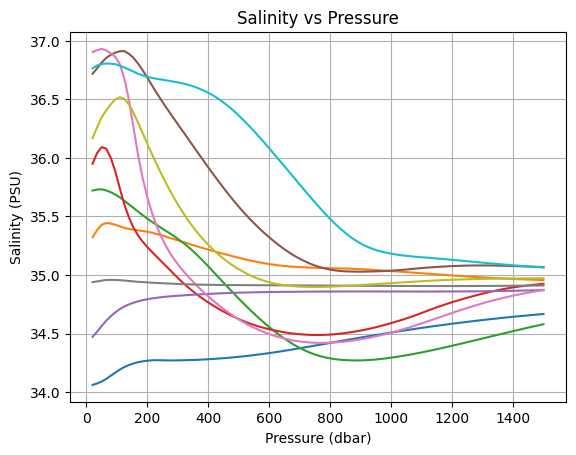

In [86]:
# Salinity vs pressure
for i in range(10):
    sns.lineplot(x = pressure, y = sal_support[:, i])
plt.title('Salinity vs Pressure')
plt.xlabel('Pressure (dbar)')
plt.ylabel('Salinity (PSU)')
plt.grid(True)
plt.savefig('img/1.png')

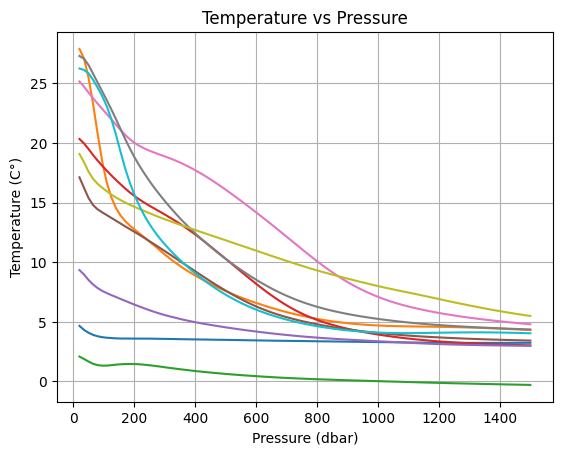

In [87]:
# Temperature vs pressure
for i in range(10):
    sns.lineplot(x = pressure, y = temp_support[:, i])
plt.title('Temperature vs Pressure')
plt.xlabel('Pressure (dbar)')
plt.ylabel('Temperature (C°)')
plt.grid(True)
plt.savefig('img/2.png')

Clasify points according the closest support point

In [60]:
def support_neighbor(X, S):
    ii = np.zeros(X.shape[1]).astype(int)
    for i in range(X.shape[1]):
        d = ((X[:, i] - S)**2).sum(1)
        ii[i] = np.argmin(d)
    return ii

In [66]:
temp_closest_support = support_neighbor(temp, temp_support.T)
salinity_closest_support = support_neighbor(psal, sal_support.T)

Plot classification maps for salinity and temperature

In [71]:
def plot_support_map(ii, title, file):
    plt.clf()
    plt.figure(figsize=(7, 8))
    plt.axes([0.1, 0.1, 0.8, 0.8])
    m = Basemap(llcrnrlon=-100.,llcrnrlat=-65.,urcrnrlon=30.,urcrnrlat=80.,
                resolution='l',projection='merc', lat_0=0.,lon_0=0.)

    for j in range(ii.max() + 1):
        jj = np.flatnonzero(ii == j)
        x, y = m(lon[jj], lat[jj])
        plt.scatter(x, y, s=8, label=str(1+j))

    ha,lb = plt.gca().get_legend_handles_labels()
    leg = plt.figlegend(ha, lb, "center right")
    leg.draw_frame(False)

    m.drawcoastlines()
    m.drawmapboundary()
    plt.title(title)
    plt.savefig(file)

/tmp/ipykernel_7103/937053369.py:14: MatplotlibDeprecationWarning: Passing the loc parameter of __init__() positionally is deprecated since Matplotlib 3.6; the parameter will become keyword-only two minor releases later.
  leg = plt.figlegend(ha, lb, "center right")


<Figure size 640x480 with 0 Axes>

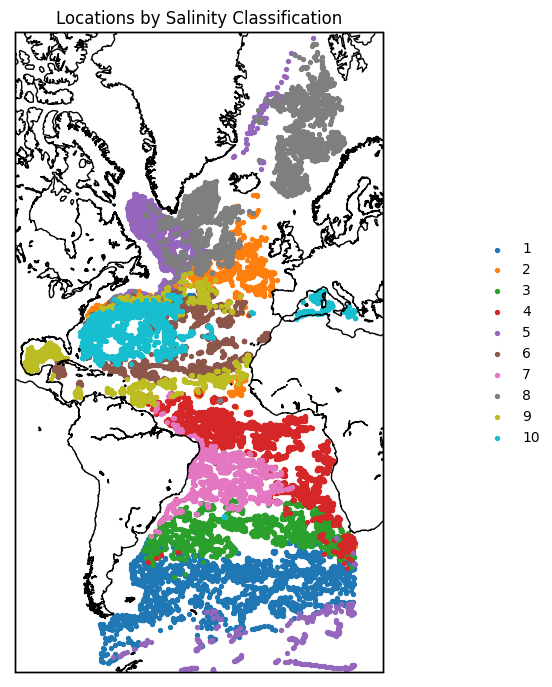

In [78]:
# Salinity
_ = plot_support_map(salinity_closest_support, 'Locations by Salinity Classification', 'img/3.png')

/tmp/ipykernel_7103/937053369.py:14: MatplotlibDeprecationWarning: Passing the loc parameter of __init__() positionally is deprecated since Matplotlib 3.6; the parameter will become keyword-only two minor releases later.
  leg = plt.figlegend(ha, lb, "center right")


<Figure size 640x480 with 0 Axes>

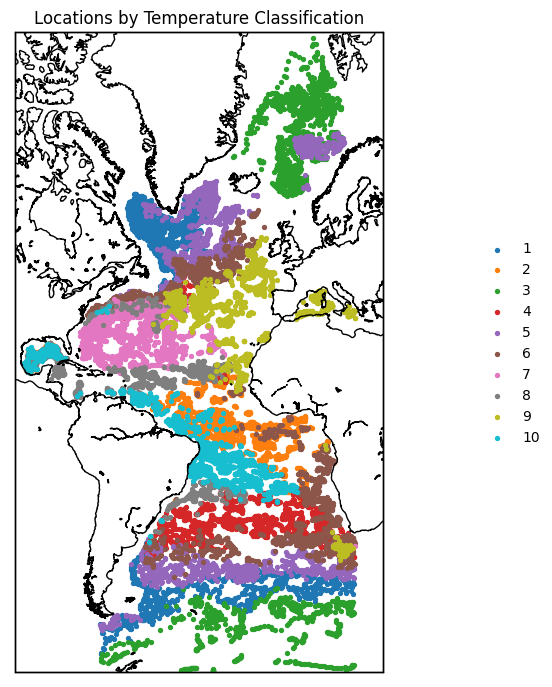

In [76]:
# Temperature 
_ = plot_support_map(temp_closest_support, 'Locations by Temperature Classification', 'img/4.png')

Generate the above plots but now for salinity and temperature stacked on the x axis.

In [81]:
# combine datasets
combined_1 = np.hstack((temp, psal))
combined_2 = np.vstack((temp, psal))

In [83]:
# Obtain support points
# First one
combined_1_support = support(combined_1.T, 10)
combined_1_support  = combined_1_support.T

# Second one
combined_2_support = support(combined_2.T, 10)
combined_2_support  = combined_2_support.T

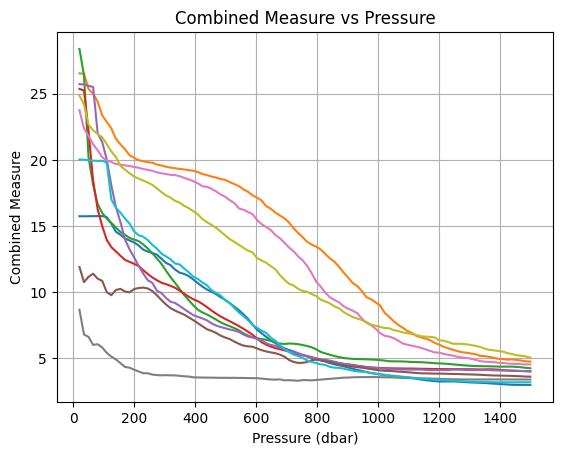

In [88]:
# Generate first plot
for i in range(10):
    sns.lineplot(x = pressure, y = combined_1[:, i])
plt.title('Combined Measure vs Pressure')
plt.xlabel('Pressure (dbar)')
plt.ylabel('Combined Measure')
plt.grid(True)
plt.savefig('img/5.png')

/tmp/ipykernel_7103/937053369.py:14: MatplotlibDeprecationWarning: Passing the loc parameter of __init__() positionally is deprecated since Matplotlib 3.6; the parameter will become keyword-only two minor releases later.
  leg = plt.figlegend(ha, lb, "center right")


<Figure size 640x480 with 0 Axes>

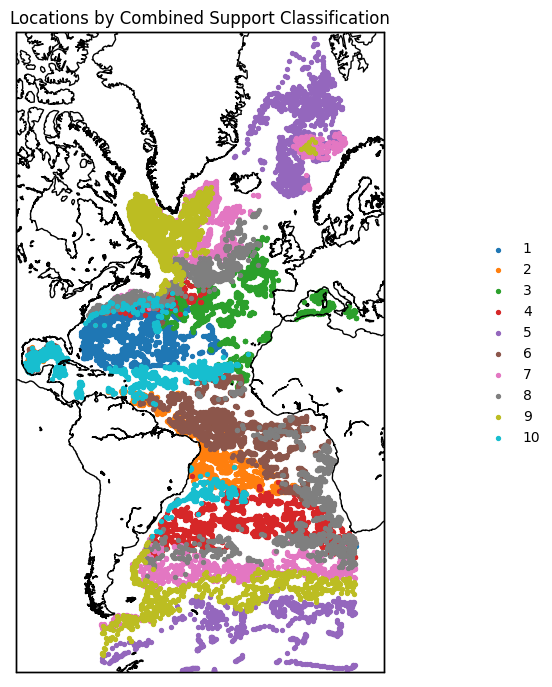

In [90]:
# Generate second plot
combined_2_closest_support = support_neighbor(combined_2, combined_2_support.T)
_ = plot_support_map(combined_2_closest_support, 'Locations by Combined Support Classification', 'img/6.png')